In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from utils.conn_data import load_pickle
from portfolio_tools.Diagnostics import Diagnostics
from functionals.Functionals import Functionals

plt.style.use('ggplot')

In [2]:
# parameters
train = True
strategy_name = "etfstsm"
diag = Diagnostics()

strategy_name = f"training_{strategy_name}" if train else strategy_name

# paths
outputs_path = os.path.join(os.getcwd(), "data", "outputs")
dirs = sorted(os.listdir(os.path.join(outputs_path, strategy_name)))

print(dirs)

['% Positive Ret._means_0.25_100', '% Positive Ret._means_0.5_100', '% Positive Ret._means_0.75_100', '% Positive Ret._means_0.95_100', '% Positive Ret._means_1.0_100', 'AvgDD_means_0.25_100', 'AvgDD_means_0.5_100', 'AvgDD_means_0.75_100', 'AvgDD_means_0.95_100', 'AvgDD_means_1.0_100', 'MaxDD_means_0.25_100', 'MaxDD_means_0.5_100', 'MaxDD_means_0.75_100', 'MaxDD_means_0.95_100', 'MaxDD_means_1.0_100', 'Sharpe_means_0.25_100', 'Sharpe_means_0.5_100', 'Sharpe_means_0.75_100', 'Sharpe_means_0.95_100', 'Sharpe_means_1.0_100']


In [3]:
dir = "Sharpe_means_0.95_100"
utility = dir.split("_")[0]
functional = dir.split("_")[1]
alpha = dir.split("_")[2] # percentile of the empirical distribution - x such that P(X <= x) = alpha
Bsize = dir.split("_")[3]

functionals = Functionals(alpha=float(alpha))

optmization_train = load_pickle(os.path.join(outputs_path, strategy_name, dir, "train_opt_results.pickle"))
portfolio_train = load_pickle(os.path.join(outputs_path, strategy_name, dir, "train_portfolio_results.pickle"))
portfolio_test = load_pickle(os.path.join(outputs_path, strategy_name, dir, "test_portfolio_results.pickle"))

In [4]:
optmization_train.keys()

dict_keys(['hyperparameters', 'utilities', 'final_utility', 'robust_parameter'])

Utility: % Positive Ret., Functional: means, Alpha: 0.25, Bsize: 100


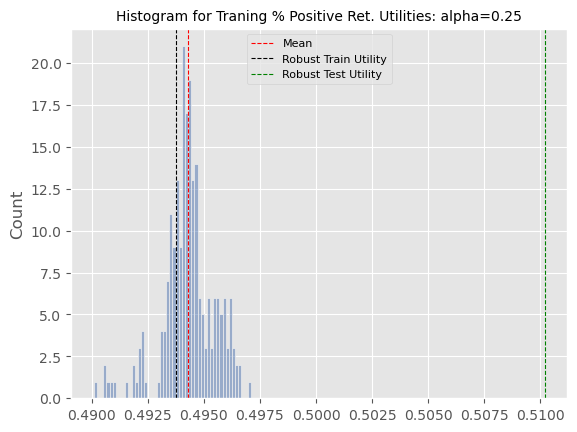

Utility: % Positive Ret., Functional: means, Alpha: 0.5, Bsize: 100


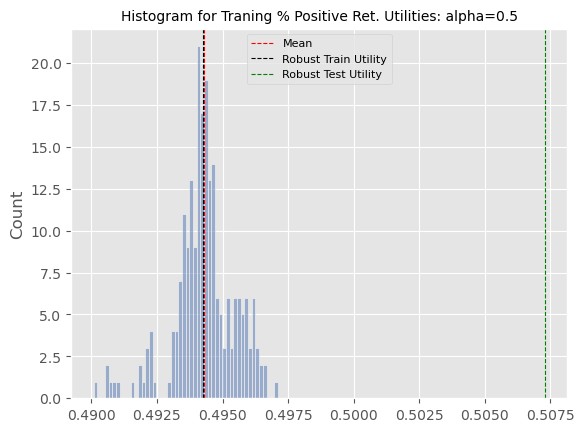

Utility: % Positive Ret., Functional: means, Alpha: 0.75, Bsize: 100


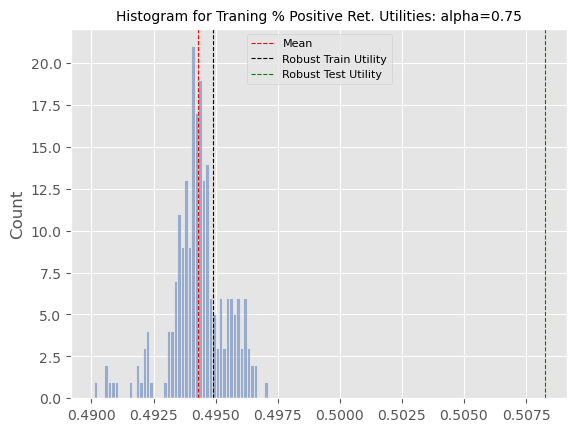

Utility: % Positive Ret., Functional: means, Alpha: 0.95, Bsize: 100


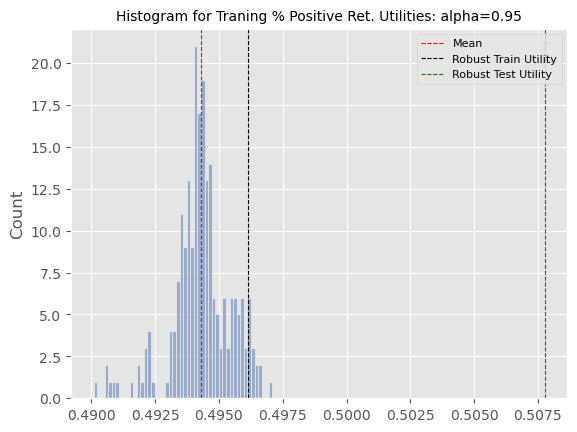

Utility: % Positive Ret., Functional: means, Alpha: 1.0, Bsize: 100


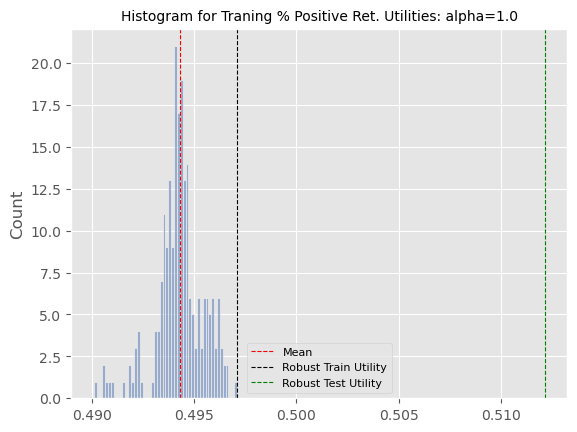

Utility: AvgDD, Functional: means, Alpha: 0.25, Bsize: 100


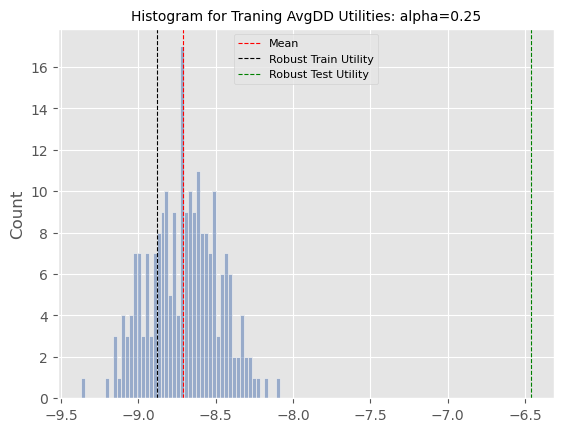

Utility: AvgDD, Functional: means, Alpha: 0.5, Bsize: 100


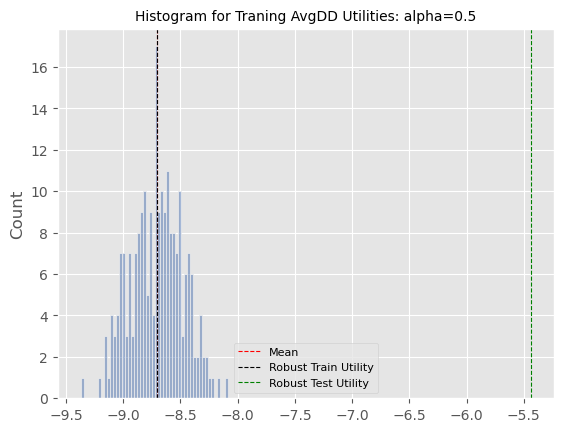

Utility: AvgDD, Functional: means, Alpha: 0.75, Bsize: 100


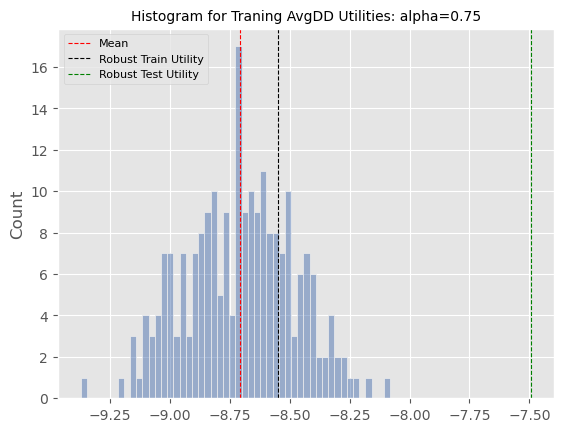

Utility: AvgDD, Functional: means, Alpha: 0.95, Bsize: 100


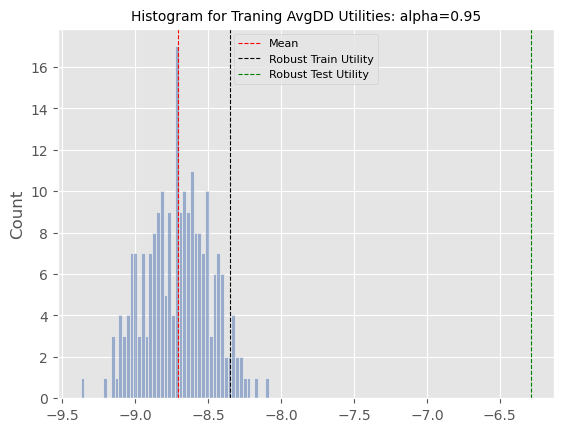

Utility: AvgDD, Functional: means, Alpha: 1.0, Bsize: 100


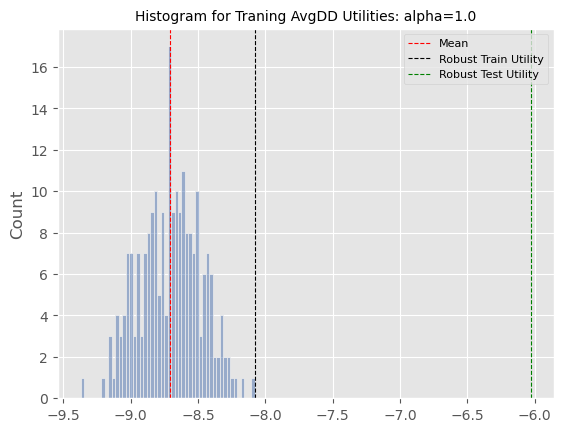

Utility: MaxDD, Functional: means, Alpha: 0.25, Bsize: 100


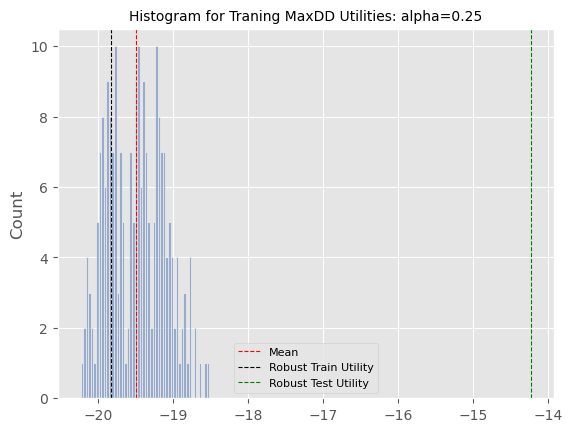

Utility: MaxDD, Functional: means, Alpha: 0.5, Bsize: 100


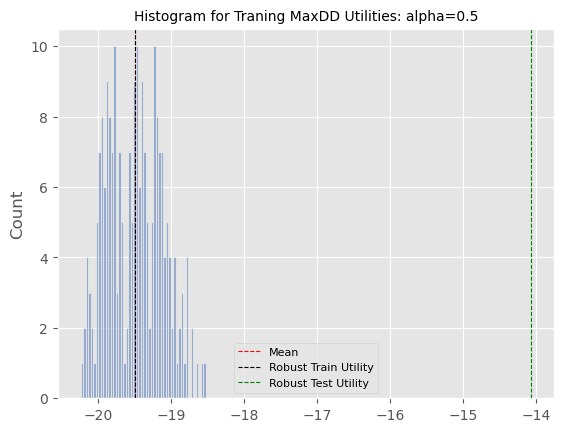

Utility: MaxDD, Functional: means, Alpha: 0.75, Bsize: 100


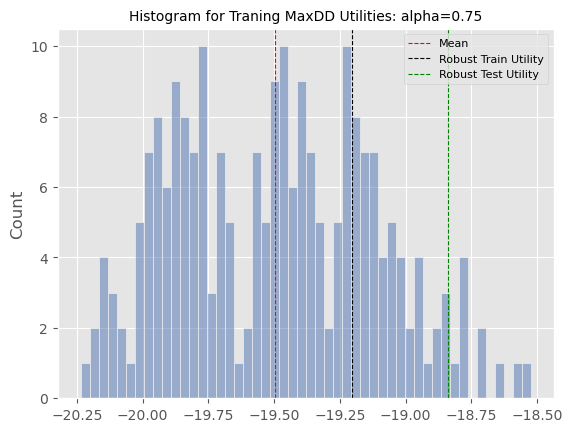

Utility: MaxDD, Functional: means, Alpha: 0.95, Bsize: 100


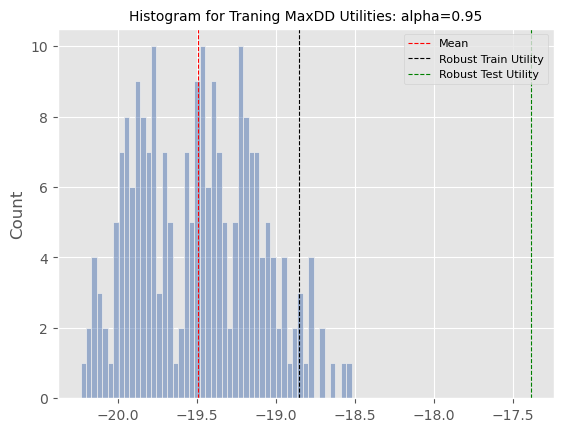

Utility: MaxDD, Functional: means, Alpha: 1.0, Bsize: 100


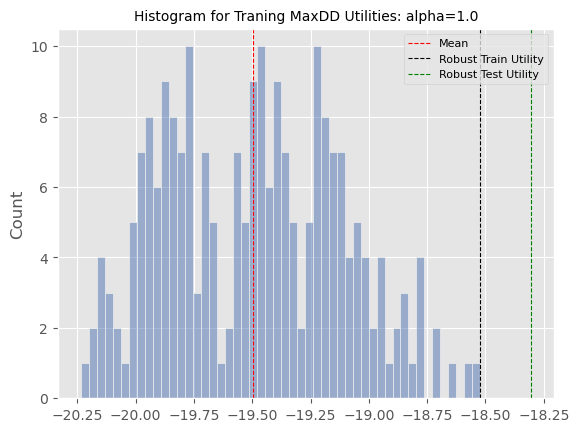

Utility: Sharpe, Functional: means, Alpha: 0.25, Bsize: 100


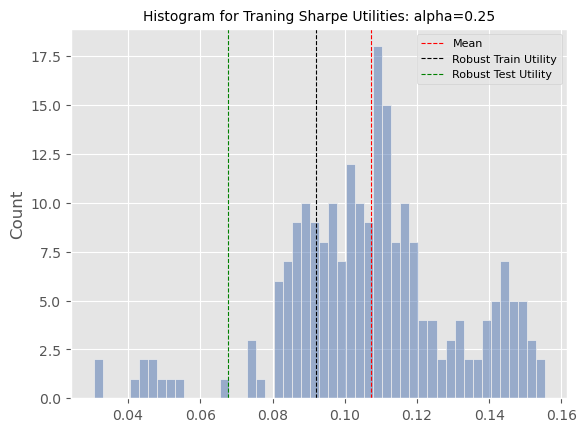

Utility: Sharpe, Functional: means, Alpha: 0.5, Bsize: 100


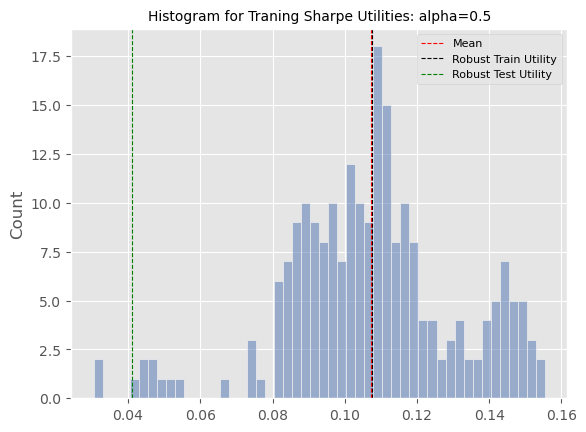

Utility: Sharpe, Functional: means, Alpha: 0.75, Bsize: 100


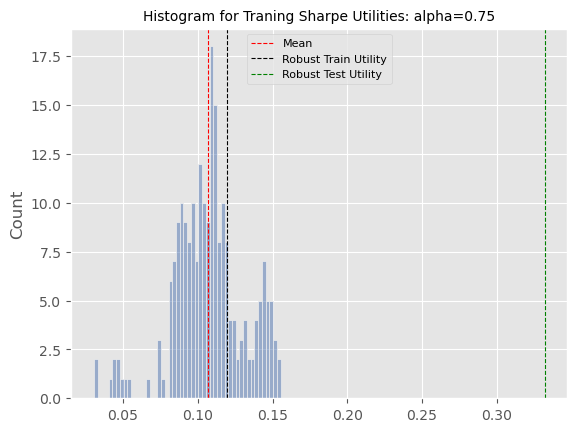

Utility: Sharpe, Functional: means, Alpha: 0.95, Bsize: 100


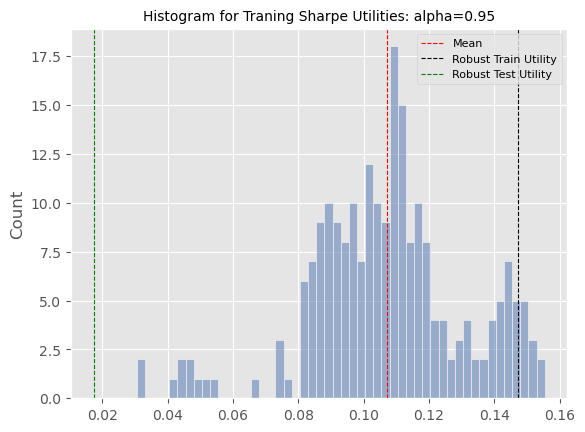

Utility: Sharpe, Functional: means, Alpha: 1.0, Bsize: 100


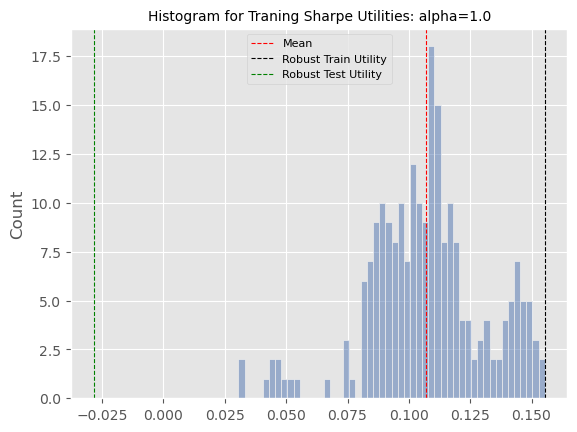

In [6]:
all_results = []
for dir in dirs:
    utility = dir.split("_")[0]
    functional = dir.split("_")[1]
    alpha = dir.split("_")[2] # percentile of the empirical distribution - x such that P(X <= x) = alpha
    Bsize = dir.split("_")[3]

    functionals = Functionals(alpha=float(alpha))

    print(f"Utility: {utility}, Functional: {functional}, Alpha: {alpha}, Bsize: {Bsize}")

    # # list files in directory
    # os.listdir(os.path.join(outputs_path, strategy_name, dir))

    optmization_train = load_pickle(os.path.join(outputs_path, strategy_name, dir, "train_opt_results.pickle"))
    portfolio_train = load_pickle(os.path.join(outputs_path, strategy_name, dir, "train_portfolio_results.pickle"))
    portfolio_test = load_pickle(os.path.join(outputs_path, strategy_name, dir, "test_portfolio_results.pickle"))

    # apply functional to vector of utility vectors
    utilities_val_train = functionals.means(x=optmization_train["utilities"])

    # get the chosen utility vector
    chosen_utility_vector_train = functionals.apply_functional(x=optmization_train["utilities"], func=functional)

    # compute robust utility
    robust_utility_train = chosen_utility_vector_train.mean()

    # portfolio results
    robust_utility_test = diag.compute_metric(portoflio_returns=portfolio_test['agg_scaled_portfolio_returns'], metric_name=utility)

    # save results
    results = {
        "Utility": utility,
        "Functional": functional,
        "Alpha": alpha,
        "Bsize": Bsize,
        "Train Utility Mean": np.round(utilities_val_train.mean().item(), 2),
        "Robust Train Utility": np.round(robust_utility_train.mean().item(), 2),
        "Robust Test Utility": np.round(robust_utility_test, 2),
        "Generalization Gap": np.round(robust_utility_test - robust_utility_train, 2).item(),
    }

    results_df = pd.DataFrame([results])
    all_results.append(results_df)

    # plot
    utility_val_df = pd.DataFrame(utilities_val_train, columns=[utility])
    ax = sns.histplot(data=utility_val_df, palette="deep", bins=50)

    plt.axvline(x=utilities_val_train.mean().item(), color='red', linestyle='--', label='Mean', linewidth=0.8)
    plt.axvline(x=robust_utility_train, color='black', linestyle='--', label='Robust Train Utility', linewidth=0.8)
    plt.axvline(x=robust_utility_test, color='green', linestyle='--', label='Robust Test Utility', linewidth=0.8)
    plt.legend(fontsize=8)
    plt.title(f"Histogram for Traning {dir.split('_')[0]} Utilities: alpha={alpha}", size=10)

    plt.show()
all_results_df = pd.concat(all_results)
all_results_df["Alpha"] = ["max" if val == "1.0" else val for val in all_results_df["Alpha"]]

In [7]:
all_results_df

,Utility,Functional,Alpha,Bsize,Train Utility Mean,Robust Train Utility,Robust Test Utility,Generalization Gap
0,% Positive Ret.,means,0.25,100,0.49,0.49,0.51,0.02
0,% Positive Ret.,means,0.5,100,0.49,0.49,0.51,0.01
0,% Positive Ret.,means,0.75,100,0.49,0.49,0.51,0.01
0,% Positive Ret.,means,0.95,100,0.49,0.50,0.51,0.01
0,% Positive Ret.,means,max,100,0.49,0.50,0.51,0.02
0,AvgDD,means,0.25,100,-8.71,-8.88,-6.46,2.42
0,AvgDD,means,0.5,100,-8.71,-8.70,-5.43,3.27
0,AvgDD,means,0.75,100,-8.71,-8.55,-7.49,1.06
0,AvgDD,means,0.95,100,-8.71,-8.35,-6.28,2.07
0,AvgDD,means,max,100,-8.71,-8.08,-6.02,2.06


In [8]:
all_results_df[["Utility", "Alpha", "Robust Train Utility", "Robust Test Utility", "Generalization Gap"]]

,Utility,Alpha,Robust Train Utility,Robust Test Utility,Generalization Gap
0,% Positive Ret.,0.25,0.49,0.51,0.02
0,% Positive Ret.,0.5,0.49,0.51,0.01
0,% Positive Ret.,0.75,0.49,0.51,0.01
0,% Positive Ret.,0.95,0.50,0.51,0.01
0,% Positive Ret.,max,0.50,0.51,0.02
0,AvgDD,0.25,-8.88,-6.46,2.42
0,AvgDD,0.5,-8.70,-5.43,3.27
0,AvgDD,0.75,-8.55,-7.49,1.06
0,AvgDD,0.95,-8.35,-6.28,2.07
0,AvgDD,max,-8.08,-6.02,2.06
